In [2]:
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html

import os
import sys
import re
import itertools
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import logging, gensim
from gensim import corpora, models, similarities,matutils
from gensim.parsing.preprocessing import STOPWORDS

import nltk
# nltk.download()
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

from scipy.spatial import distance

import sklearn.datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

In [3]:
# # Load Data
# corpus = corpora.MmCorpus('20newsgroup.mm')
# dictionary = corpora.Dictionary.load('20newsgroup.dict')

In [4]:
train = sklearn.datasets.fetch_20newsgroups(subset='train',remove=('headers','footers','quotes'))
# train = sklearn.datasets.fetch_20newsgroups(subset='train')
test = sklearn.datasets.fetch_20newsgroups(subset='test')
s = nltk.stem.SnowballStemmer('english')
#train.target_names
#train.filenames
#train.target[:10]
documents = train.data

In [87]:
class Token_Corpus20News(object):
    def __init__(self,corpus):
        self.corpus = corpus

    def __iter__(self):
        for text in self.corpus:
            text = gensim.utils.to_unicode(text, 'latin1').strip()
            # tokenize each message; simply lowercase & match alphabetic chars, for now
            yield self.tokenize(text)
            
    def tokenize(self, text):
        token = gensim.utils.tokenize(text,lower=True)
        return list(set([s.stem(t) for t in token if t.lower() not in STOPWORDS and len(t)>3]))

tokenized_corpus = Token_Corpus20News(documents)

# print the first two tokenized messages
# print(list(itertools.islice(tokenized_dict,10)))
# print(list((itertools.islice(iter_group_post(documents),5))))

In [144]:
# # nltk.download()
# # test = word_tokenize(documents[1])
# tokenizer = RegexpTokenizer(r'\w+')

# stop = stopwords.words('english')
# texts = []

# # [texts.append(set([s.stem(word) for sent in sent_tokenize(doc) for word in tokenizer.tokenize(sent) if word.lower() not in stop])) for doc in documents]

# # stopwords are in lower case ... 
# # for doc in documents:
# #     for sent in sent_tokenize(doc):
# #         texts.append([s.stem(word) for word in tokenizer.tokenize(sent) if word.lower() not in stop])

# for doc in documents:
#     texts.append([s.stem(word) for word in tokenizer.tokenize(doc) if word.lower() not in stop])

In [34]:
# dictionary = corpora.Dictionary(line.lower().split() for line in open('mycorpus.txt'))
# Maps a word to a ID
# () - Hashable - can be used for dictionary - Tuples
# [] - Lists
# doc_stream = (tokens for tokens in tokenized_corpus)
dictionary = corpora.Dictionary(tokenized_corpus)
# ignore words that appear in less than 20 documents or more than 10% documents
dictionary.filter_extremes(no_below=20, no_above=0.1)
dictionary.save('20newsgroup.dict') # store the dictionary, for future reference
print(dictionary)
# print(dictionary.token2id)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary(46442 unique tokens: ['parrot', 'completest', 'analisi', 'sportscast', 'compuserv']...)
INFO:gensim.corpora.dictionary:built Dictionary(49970 unique tokens: ['tkzh', 'parrot', 'completest', 'analisi', 'sportscast']...) from 11314 documents (total 554876 corpus positions)
INFO:gensim.corpora.dictionary:discarding 46135 tokens: [('funki', 6), ('year', 1473), ('bricklin', 3), ('know', 2470), ('look', 1572), ('tellm', 1), ('thank', 1398), ('like', 2771), ('macleak', 2), ('time', 2053)]...
INFO:gensim.corpora.dictionary:keeping 3835 tokens which were in no less than 20 and no more than 1131 (=10.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(3835 unique tokens: ['pilot', 'marshal', 'anybodi', 'path', 'mormon']...)
INFO:gensim.utils:saving Dictionary object under 20newsgroup.dict, separately None


Dictionary(3835 unique tokens: ['pilot', 'marshal', 'anybodi', 'path', 'mormon']...)


In [39]:
class News20Corpus(object):
    def __init__(self, group_post, dictionary):
        """
        Parse the first `clip_docs` Wikipedia documents from file `dump_file`.
        Yield each document in turn, as a list of tokens (unicode strings).
        
        """
        self.group_post = group_post
        self.dictionary = dictionary
    
    def __iter__(self):
        for tokens in self.group_post:
            yield self.dictionary.doc2bow(tokens)
            
corpus = News20Corpus(tokenized_corpus,dictionary)
%time gensim.corpora.MmCorpus.serialize('20newsgroup.mm', corpus)
# newsgrp20 = [dictionary.doc2bow(doc_stream) for post in texts]
# corpora.MmCorpus.serialize('20newsgroup.mm', newsgrp20) # store to disk, for later use
# newsgrp20 = corpora.MmCorpus('20newsgroup.mm')
# Word ID , Frequency for each document
# print(newsgrp20)

mm_corpus = gensim.corpora.MmCorpus('20newsgroup.mm')
print(mm_corpus)

In [48]:
# clipped_corpus = gensim.utils.ClippedCorpus(mm_corpus, 4000)  # use fewer documents during training, LDA is slow
%time lda_model = gensim.models.LdaModel(mm_corpus, num_topics=100, id2word=dictionary, passes=4)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.01
INFO:gensim.models.ldamodel:using symmetric eta at 0.01
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online LDA training, 100 topics, 4 passes over the supplied corpus of 11314 documents, updating model once every 2000 documents, evaluating perplexity every 11314 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/11314
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 11314 documents
INFO:gensim.models.ldamodel:topic #2 (0.010): 0.007*mean + 0.006*advanc + 0.005*help + 0.005*assembl + 0.005*physic + 0.005*make + 0.004*have + 0.004*part + 0.004*copi + 0.004*understand
INFO:gensim.models.ldamodel:topic #66 (0.010): 0.006*stuff + 0.006*avail + 0.005*littl + 0.005*sound + 0.004*inform + 0.004*hard + 0.004*chang + 0.004*nice + 0.004*offic + 0.004*graphic
INFO:gensim.mode

Wall time: 1min 41s


In [123]:
# tfidf = models.TfidfModel(newsgrp20) # Initialize Tfidf
# corpus_tfidf = tfidf[newsgrp20] # Transform Test Corpus

# lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
# corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: corpus->tfidf->fold-in-lsi

# lda_model = models.ldamodel.LdaModel(newsgrp20, id2word=dictionary, num_topics=100,passes=10)
# model = hdpmodel.HdpModel(bow_corpus, id2word=dictionary)

doc_num = 1000

# Returns Topic + Probability of Topic
lda_vector = lda_model[mm_corpus[doc_num]]
# Prints the most likely Topic. Performs Max based on the 2nd element in the tuple
print(max(lda_vector, key=lambda item: item[1]))
print(lda_model.print_topic(max(lda_vector, key=lambda item: item[1])[0]))
print(documents[doc_num])

# pred_topic = lda_model[mm_corpus[doc_num]]
# # print("Topic-(Topic Index,Probability)",pred_topic)
# print(documents[doc_num])
# for x,y in sorted(pred_topic, key=lambda tup: tup[1],reverse=True)[:3]:
#     print("Topic----",y)
#     for terms,prob in lda_model.get_topic_terms(x,10):
#         print("Terms - ",dictionary[terms]," ",prob)


    

(78, 0.65881219021354631)
0.028*anybodi + 0.025*hello + 0.022*printer + 0.022*help + 0.022*monitor + 0.020*print + 0.019*advanc + 0.017*compat + 0.017*color + 0.015*board
Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
if anyone else had seen this.

post or email


(array([  2.14400000e+03,   4.09000000e+03,   2.85100000e+03,
          1.28800000e+03,   5.68000000e+02,   2.55000000e+02,
          7.80000000e+01,   2.50000000e+01,   1.20000000e+01,
          3.00000000e+00]),
 array([  0. ,   3.9,   7.8,  11.7,  15.6,  19.5,  23.4,  27.3,  31.2,
         35.1,  39. ]),
 <a list of 10 Patch objects>)

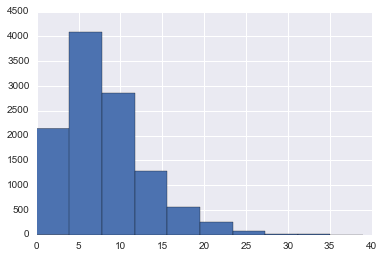

In [124]:
num_topics = [len(lda_model[doc]) for doc in mm_corpus]
plt.hist(num_topics)

In [86]:
# x = np.array([[1,2],[2,4]])
# print("x ",x.shape) - 2,2
# y = np.array([[1,2],[2,4]])
# print("x ",y.shape) 

x  (2, 2)


In [59]:
# s = nltk.stem.SnowballStemmer('english')
# class StemmedTfidfVectorizer(TfidfVectorizer):
#     def build_analyzer(self):
#         #StemmedCountVectorizer will return CountVectorizer build_analyzer code
#         analyzer = super(TfidfVectorizer,self).build_analyzer()
#         return lambda doc: (s.stem(w) for w in analyzer(doc))

# # default min_df = 1, max_df = 1.0
# # In other words, tf-idf weight in document that is
# # highest when the terms occurs many times within a small number of documents (thus lending high discriminating power to those documents);
# # lower when the term occurs fewer times in a document, or occurs in many documents (thus offering a less pronounced relevance signal);
# # lowest when the term occurs in virtually all documents.
# vectorizer = StemmedTfidfVectorizer(min_df=1,stop_words='english',decode_error='ignore')

# vectorized = vectorizer.fit_transform(documents)
# features = np.array(vectorizer.get_feature_names())
# # type(features)
# texts = [list(features[list((vectorized>0)[i].nonzero()[1])]) for i,doc in enumerate(documents)]